# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data importing
Helper function that will help transforming the string that represents a list in the Excel file, to an actual Python list

In [5]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("[]").replace("'", "").replace('"', "").split(", ")]

def single_list_string_to_string(column):
    return column[2:-2]

In [6]:
PATH = 'data/'

recensement = pd.read_excel(PATH + '1832_cleaned_data_recensement.xlsx')
recensement["PROPRIÉTAIRES DES MAISONS."] = recensement["PROPRIÉTAIRES DES MAISONS."].apply(string_to_list)
recensement["NOMS DES RUES."] = recensement["NOMS DES RUES."].apply(single_list_string_to_string)

cadastre = pd.read_excel(PATH + 'legende.xlsx')
cadastre["use"] = cadastre["use"].apply(string_to_list)


n_folio_9 = len(cadastre[cadastre["folio"] == 9]["nr"].unique())
print(n_folio_9)
folio9gsj = cadastre[(cadastre["folio"] == 9) & (cadastre["nr"] >= 107) & (cadastre["nr"] < 239)]
print(len(folio9gsj))



folio_streets = pd.DataFrame({"folio" : [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8 ,8, 8, 8, 9, 9, 9, 9, 10, 10 ,10, 11, 11], "street" : ["Rue du Petit Chêne", "Rue du Grand Chêne", "Descente de Pépinet", "Chemin du Pas des anes", "Derrière les Terraux",
                                                                    "Place de Saint-François", "Descente de Pépinet", "Montée de Saint-François", "Derrière Saint-François",
                                                                    "Rue de Saint-Pierre", "Rue de Bourg", "Derrière Bourg", "Rue Cheneau de Bourg", "Rue du Pré", "Montée de Saint-François", "Ruelle Saint-Pierre",
                                                                    "Martherey", "Rue d'Etraz", "Chemin derrière Etraz",
                                                                    "Martherey",
                                                                    "Rue de la Cité devant", "Rue de la Cité derrière",
                                                                    "Rue de l'Hopital", "Rue du Pré", "Derrière les Chenaux" ,"Rue de l'Etienne", "Rue de la Cité derrière",
                                                                    "Place de la Palud", "Rue de la Mercerie", "Rue du Petit Saint-Jean", "Place du Pont", "Rue du Pont", "Rue des Escaliers du Marché", "Rue de la Madelaine",
                                                                    "Montée de Saint-Laurent", "Place de Saint-Laurent", "En Pépinet", "Grand Saint Jean",
                                                                    "Rue de Saint-Laurent", "Rue du Chaucrau", "Derrière Saint-Laurent",
                                                                    "Rue de l'hâle de Saint-Laurent", "Derrière l'Hâle de Saint-Laurent"]})


cadastre = pd.merge(cadastre, folio_streets, left_on = "folio", right_on = "folio", how="inner")



folio_streets.head(10)

XLRDError: Excel xlsx file; not supported

In [29]:
recensement.head(5)

,Unnamed: 0,NOMS DES RUES.,N° des MAISONS.,PROPRIÉTAIRES DES MAISONS.,NOMS DES CHEFS DE FAMILLE ET AUTRES LOCATAIRES. NOMS DE BAPTÊME.,NOMS DES CHEFS DE FAMILLE ET AUTRES LOCATAIRES. NOMS DE FAMILLE.,Année de la naissance. [h],NOMS DE LEURS ÉPOUSES.,Année de la naissance. [f],Noms de leurs enfans actuellement dans la Commune.,...,Date de leur demeure dans la Commune.,VOCATION.,N° de leur Récépissé. [famille],"NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE BAPTÊME.","NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE FAMILLE.","D'où ils sont bourgeois, ou à ce défaut d'où ils sont originaires. [dom/pens]","Indiquer ici s'ils sont Pensionnaires, Commis, Apprentis, Ouvriers ou Domestiques.",N° de leur Récépissé. [dom/pens],OBSERVATIONS.,Page
0,0,Martherey,['7'],[Gilliéron],['Jean Louis'],"[['Deprez', 'Devez']]",['1768'],"[['Echs', 'Ochs']]",['1793'],"[['Laura', 'Lucia', 'Lucy']]",...,['1831'],"['journalier', 'journalier']",[],[],[],[],[],[],[],3
1,1,Martherey,['7'],[],"[['Jean Andre', 'Jean Marc', 'Jean Marie', 'Je...",['Fontannaz'],['1778'],"['Sophprant', 'Loretti']",['1778'],"['Jeanne', 'Jeanne', 'Abram', 'Jeannette', ['D...",...,['1812'],"['journalier', 'journalier']",['1525'],[],[],[],[],[],[],3
2,2,Martherey,['7'],[],['Marie Louis'],"[['Guerry', 'Minery', 'Querry', 'Terry', 'Thie...",['1774'],['Chavan'],['1777'],"[['Louis', 'Louisa', 'Louise', 'Louison'], 'In...",...,['né'],['vigneron'],[],[],[],[],[],[],[],3
3,3,Martherey,['7'],[Cherbouin],['Henry'],['Cherbuin'],['1798'],['Perret'],['1793'],"['Louise', 'Samuel']",...,['1812'],['charpentier'],['2212'],[],[],[],[],[],[],3
4,4,Martherey,['7'],[],['Jaques'],['Mermoud'],['1780'],[],[],[],...,['1830'],['manoeuvre'],[],[],[],[],[],[],[],3


In [30]:
cadastre.head(5)

,Unnamed: 0,folio,nr,articles,use,owner_surname,Unnamed: 6,street
0,0,1,1.0,NaN,"[place, passage]",Commune de Lausanne,NaN,Rue du Petit Chêne
1,0,1,1.0,NaN,"[place, passage]",Commune de Lausanne,NaN,Rue du Grand Chêne
2,0,1,1.0,NaN,"[place, passage]",Commune de Lausanne,NaN,Descente de Pépinet
3,0,1,1.0,NaN,"[place, passage]",Commune de Lausanne,NaN,Chemin du Pas des anes
4,0,1,1.0,NaN,"[place, passage]",Commune de Lausanne,NaN,Derrière les Terraux


# Visualisations
## Distribution of uses

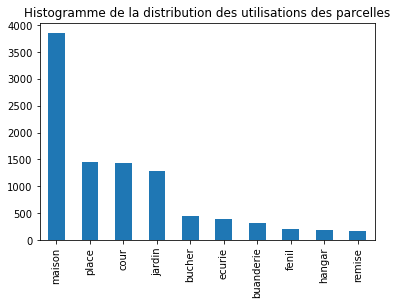

In [31]:
cadastre.explode("use")["use"].value_counts()[:10].plot(kind='bar', title="Histogramme de la distribution des utilisations des parcelles")

## Who possesses the most terrain ?

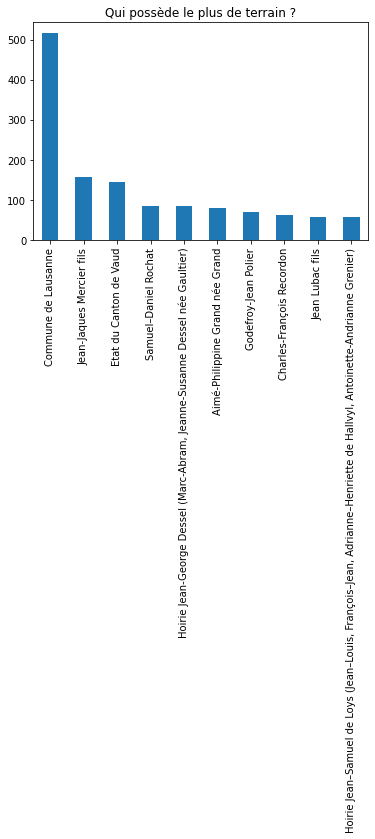

In [32]:
cadastre.owner_surname.value_counts()[:10].plot(kind="bar", title = "Qui possède le plus de terrain ?")

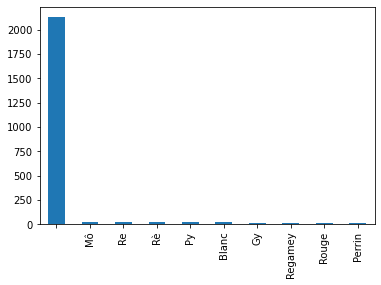

In [33]:
recensement.explode("PROPRIÉTAIRES DES MAISONS.")["PROPRIÉTAIRES DES MAISONS."].value_counts()[:10].plot(kind='bar')

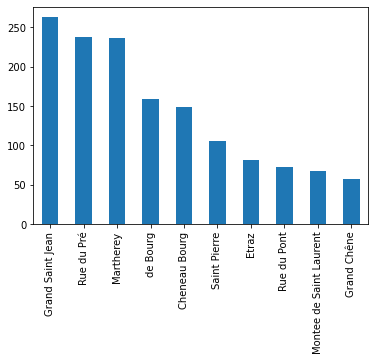

In [34]:
recensement["NOMS DES RUES."].value_counts()[:10].plot(kind='bar')

# Merging the two datasets
Before trying to merge, we must "explode" the recensement dataset such that we get one entry for each owner. Meaning that if an entry has owner [A, B], it should create two entries, the first one belonging to A only and the second one to B only. We then only keep an entry if it has an owner

In [35]:
recensement_exploded = recensement.explode("PROPRIÉTAIRES DES MAISONS.")
recensement_exploded = recensement_exploded[recensement_exploded["PROPRIÉTAIRES DES MAISONS."].str.len() > 0]

We will first try to merge the two datasets given the full owner names from both datasets. Sadly, it yields an empty dataset, which mean we cannot match them this way. This is mostly due to the fact that the owner_surnames in the cadastre DataFrame actually also contain first names and other indications.

In [36]:
pd.merge(cadastre, recensement.explode("PROPRIÉTAIRES DES MAISONS."), left_on = "owner_surname", right_on = "PROPRIÉTAIRES DES MAISONS.", how = "inner")

,Unnamed: 0_x,folio,nr,articles,use,owner_surname,Unnamed: 6,street,Unnamed: 0_y,NOMS DES RUES.,...,Date de leur demeure dans la Commune.,VOCATION.,N° de leur Récépissé. [famille],"NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE BAPTÊME.","NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE FAMILLE.","D'où ils sont bourgeois, ou à ce défaut d'où ils sont originaires. [dom/pens]","Indiquer ici s'ils sont Pensionnaires, Commis, Apprentis, Ouvriers ou Domestiques.",N° de leur Récépissé. [dom/pens],OBSERVATIONS.,Page


Because of this flaw, let's try to split the owner names on blank spaces in the cadastre dataset and explode it as well

In [37]:
cadastre["owner_names"] = cadastre["owner_surname"].apply(lambda name : name.split(" "))
cadastre_exploded = cadastre.explode("owner_names")

We can now try to merge again

In [38]:
merged = pd.merge(cadastre_exploded, recensement_exploded, left_on = "owner_names", right_on = "PROPRIÉTAIRES DES MAISONS.", how="inner")

We now get 7562 results, which is not bad. Of course the current matching is not a 1-to-1 function as it should be. Rather, a terrain is matched to all entries in the recensement belonging to the same person. A 1-to-1 matching will probably require manual work.

Moreover, we only match on the surname, which means that there are probably some mistake in the current matching

In [39]:
merged = pd.merge(cadastre_exploded, recensement_exploded, left_on = ["owner_names", "street"], right_on = ["PROPRIÉTAIRES DES MAISONS.", "NOMS DES RUES."], how="inner")
merged.head(5)

,Unnamed: 0_x,folio,nr,articles,use,owner_surname,Unnamed: 6,street,owner_names,Unnamed: 0_y,...,Date de leur demeure dans la Commune.,VOCATION.,N° de leur Récépissé. [famille],"NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE BAPTÊME.","NOMS DES PENSIONNAIRES, COMMIS, APPRENTIS, OUVRIERS ET DOMESTIQUES. NOMS DE FAMILLE.","D'où ils sont bourgeois, ou à ce défaut d'où ils sont originaires. [dom/pens]","Indiquer ici s'ils sont Pensionnaires, Commis, Apprentis, Ouvriers ou Domestiques.",N° de leur Récépissé. [dom/pens],OBSERVATIONS.,Page
0,291,3,1.0,NaN,[maison],Jean–Jacques Buffat,NaN,Rue du Pré,Buffat,1082,...,[],"['charpentier', 'marchand']","['153', '1192']","['1t Albort Jcophile', ['Antoine', 'Antonie', ...","['Lutstorf', 'Aubertet', ['Boeuf', 'Guelfo', '...","['Bern', 'Bavois', 'de llouabe', ['Binn', 'Sax...","['pensionnaire', 'pensionnaire', 'pensionnaire...","['15813', '16466', '16633', '16742', '13634', ...",[],50
1,297,3,6.0,NaN,"[maison,boutique]","Louis–Daniel Vincent, Louise Vincent née Basti...",NaN,Rue du Pré,Vincent,1000,...,['1790'],['proprietaire'],['174'],['Marguerite'],"[['Bovel', 'Bruel', 'Brunel', 'Burel', 'Curel'...",['pe tne Levre'],['domestique'],['2074'],[],47
2,315,3,24.0,NaN,[maison],Hoirie David–Emmanuel Vincent (Marie–Henriette...,NaN,Rue du Pré,Vincent,1000,...,['1790'],['proprietaire'],['174'],['Marguerite'],"[['Bovel', 'Bruel', 'Brunel', 'Burel', 'Curel'...",['pe tne Levre'],['domestique'],['2074'],[],47
3,316,3,25.0,NaN,[place],Hoirie David–Emmanuel Vincent (Marie–Henriette...,NaN,Rue du Pré,Vincent,1000,...,['1790'],['proprietaire'],['174'],['Marguerite'],"[['Bovel', 'Bruel', 'Brunel', 'Burel', 'Curel'...",['pe tne Levre'],['domestique'],['2074'],[],47
4,403,3,113.0,NaN,[maison],Henri-Emanuel Vincent,NaN,Rue du Pré,Vincent,1000,...,['1790'],['proprietaire'],['174'],['Marguerite'],"[['Bovel', 'Bruel', 'Brunel', 'Burel', 'Curel'...",['pe tne Levre'],['domestique'],['2074'],[],47


In [44]:
grand_st_jean = merged[(merged["street"] == "Grand Saint Jean") & (merged["nr"] >= 105) & (merged["nr"] < 247)]
#r_grand_st_jean = recensement[recensement[ "NOMS DES RUES."] == "Grand Saint Jean"]

#print(len(r_grand_st_jean))



n_grand_st_jean_unique = len(grand_st_jean["nr"].unique())
n_grand_st_jean_not_unique = len(grand_st_jean[grand_st_jean["nr"].duplicated()])



print(f"{n_grand_st_jean_unique} parcelles uniques du folio 9 sur {len(folio9gsj)} correspondent à une entrée du recensement sur la rue du Grand Saint Jean, c'est-à-dire {n_grand_st_jean_unique/len(folio9gsj)*100}%")
print(f"De plus, {n_grand_st_jean_not_unique} entrées sont ambigues, donc {n_grand_st_jean_not_unique/len(grand_st_jean)*100}%")

84 parcelles uniques du folio 9 sur 136 correspondent à une entrée du recensement sur la rue du Grand Saint Jean, c'est-à-dire 61.76470588235294%
De plus, 25 entrées sont ambigues, donc 22.93577981651376%


In [41]:
merged[merged["street"] == "Grand Saint Jean"].drop(["Unnamed: 0_x", "Unnamed: 0_y"], axis=1).to_excel("grand_saint_jean.xlsx")

FileCreateError: [Errno 13] Permission denied: 'grand_saint_jean.xlsx'